In [51]:
# 환경구축 : requirements.txt + pandas install
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(action='ignore')

import os

path = '/opt/ml/input/data/train/'

train = pd.read_csv(path + 'train_ratings.csv')

year_data = pd.read_csv(os.path.join(path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(path, 'directors.tsv'), sep='\t')

## 데이터 분포 확인해보기

In [52]:
print(train.shape[0])

5154471


In [53]:
train.nunique()

user      31360
item       6807
time    5074973
dtype: int64

In [54]:
np.round((1 - train.shape[0] / (train['user'].nunique() * train['item'].nunique())) * 100,4)

97.5854

In [55]:
sum(train[['user', 'item']].duplicated()) # duplicated : 똑같은 값이 존재하면 True를 보내줍니다.

0

유저수 약 3만명, 영화 수 6800여개 존재합니다. 

총 데이터는 5154471개 있는데 대부분 time 변수는 겹치지 않습니다.

미션 EDA에도 존재하지만 간단하게 Sparse Ratio을 구해보면 약 97.58%로 꽤 Dense합니다.

가공된 데이터라 그런지 실제 유저-아이템 상호작용 데이터보다 모델링 하기에는 좋은 환경으로 생각됩니다.

중복된 값이 없는걸로 보아 같은 유저가 영화를 시청한 기록이 여러 개 있진 않아보입니다.

2강 강의 6쪽에 있는 $C_{ui}$ 가중치 함수를 쓸 환경은 나오지 않을 것 같습니다.

또 test set이 동일한 환경에 있다고 가정한다면 이미 본 영화를 추천해서는 안될 것 같아요.

In [56]:
train['user'].value_counts()

8405      2912
54465     1980
24219     1842
32514     1830
91349     1795
          ... 
11211       32
128756      28
105578      22
68606       19
53188       16
Name: user, Length: 31360, dtype: int64

8405번 유저가 거의 3000편의 영화를 보았는데요. 유별나신 이 분을 제외하고는 2천편 아래로 기록되어 있습니다.

고무적인 것은 가장 적게 본 유저도 16개의 영화시청 기록을, 하위 4명을 제외하고는 최소 30편 이상 영화시청 기록이 있습니다.

Cold Start 유저가 존재하지 않는 이상적인 데이터 구조로 생각됩니다.

<AxesSubplot: >

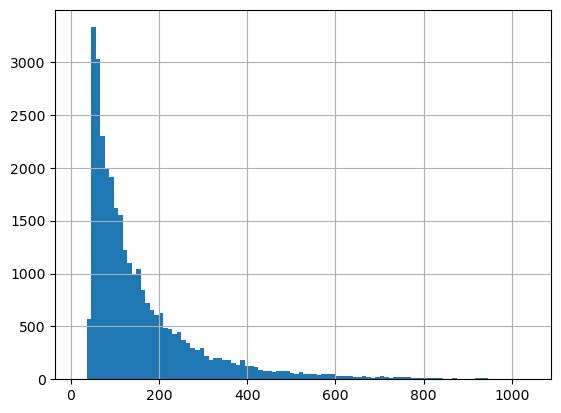

In [57]:
train['user'].value_counts()[100:].hist(bins=100) # bins : 구간을 나눠 촘촘한 히스토그램을 그려줍니다.

극단적으로 많은 상위 100명을 제외한 유저의 영화시청 개수 히스토그램을 그려봤습니다.

대부분 유저들은 100편 넘게 보진 않은 것 같아요.

In [58]:
train['item'].value_counts()

2571     19699
2959     18437
296      18202
318      18168
356      17339
         ...  
7259        38
126         36
4241        34
2555        34
51372       27
Name: item, Length: 6807, dtype: int64

implicit 데이터를 사용하는 첫 대회여서 많이 기록되어있는것이 인기가 있다고 판단해도 되나 싶은데요.

인기 있는 영화는 2만편 가까이 기록되어있는 것도 있고 1개 영화를 제외하고는 최소 30명은 시청기록이 있는 영화들입니다.

<AxesSubplot: >

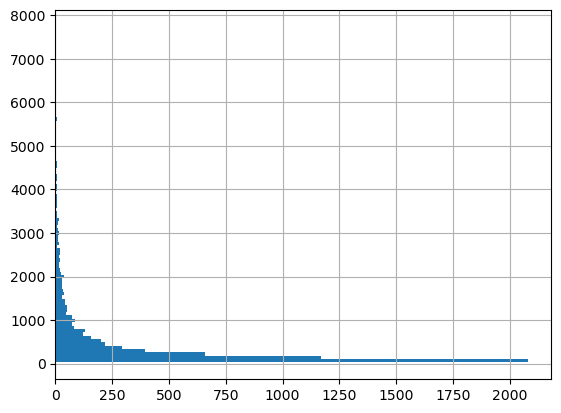

In [59]:
train['item'].value_counts()[100:].hist(orientation='horizontal', bins=100)

![image](https://user-images.githubusercontent.com/79916736/207185028-f2c290d6-e959-42fe-b802-d03400c0d0cb.png)

히스토그램을 이용해 Long Tail Phenomenon이 얼마나 일어나는지를 그려보았습니다.

많은 유저의 시청 기록이 있는 영화가 인기도가 높다고 할 때 히스토그램을 가로로 눕히면 우리 데이터를 아래 그림에 맞게 시각화한 것입니다.

인기 상위 100개를 자르고 히스토그램을 그렸는데도 불구하고 인기 있는 상품에 상당히 편향된 모습입니다.

## 타임라인 분석해보기

In [60]:
import time

# 약 20초정도 소요됩니다.
train['log_year'] = train['time'].apply(lambda x : time.strftime('%Y', time.localtime(x)))
train['month'] = train['time'].apply(lambda x : time.strftime('%m', time.localtime(x)))

train['log_year'] = train['log_year'].astype('int')
train['month'] = train['month'].astype('int')
train.sample(3)

,user,item,time,log_year,month
3867173,103253,7361,1300824072,2011,3
4584033,122635,588,1339762449,2012,6
2415055,64111,370,1126989421,2005,9


데이터 내 unix time을 미션 EDA에 존재하는 time 내 함수를 응용하여 연도와 달을 구했습니다.

In [61]:
train['log_year'].value_counts().sort_index() # sort_index : 인덱스(연도) 기준 정렬.

2005    572894
2006    647240
2007    589945
2008    679269
2009    517366
2010    510385
2011    427103
2012    421942
2013    338109
2014    308281
2015    141937
Name: log_year, dtype: int64

연도별로 영화 시청 기록 개수가 어떻게 변하는지 살펴봤습니다. 2006년과 2008년에는 영화가 흥행한 시즌인 것 같네요.

이 값을 보고 두 가지 가설을 새워볼 수 있을 것 같아요. 

1) 점점 영화 인기가 떨어져서 기록이 준다. 2) 시퀀셜하게 데이터를 분할했기 때문에 당연히 뒷 데이터가 적다.

어느 가설이 맞는지는 더 정밀한 데이터 분석이 추가로 필요할 것 같습니다.

만약 2번 가설이 맞다면 2011년부터 유의미하게 기록이 줄어드는 것은 한 시점을 기준으로 test set을 만들기 보다는 유저마다 다른 시점으로 test set을 만들었다고 개인적으로 생각됩니다.

In [62]:
train['month'].value_counts().sort_index()

1     508889
2     417357
3     432249
4     406257
5     439160
6     414722
7     440935
8     386369
9     390955
10    442310
11    444009
12    431259
Name: month, dtype: int64

북반구 데이터라고 가정했을 때 봄, 가을 등 날씨가 좋을 때는 영화 시청 기록이 떨어지는 군요.

겨울에 실내 데이트를 많이한다는 직관과 일치하는 모습입니다. 특히 연초에 많은 기록이 있네요.

In [63]:
train[train['log_year'] != 2015]['month'].value_counts().sort_index()

1     454177
2     373320
3     389061
4     406257
5     439160
6     414722
7     440935
8     386369
9     390955
10    442310
11    444009
12    431259
Name: month, dtype: int64

혹시나 2015년 데이터가 상대적으로 많이 적은데 연초에 편향되어있지 않나 해서 2015년을 빼고 다시 관찰했습니다.

1월이 값이 가장 크나 조금은 거품이 있던 모양이고 2월은 28일밖에 없는 것도 나름 큰 요인으로 추정됩니다.

## 메타 데이터 분석해보기

In [64]:
print('영화 개수 :',train['item'].nunique())
print('연도 기록 개수:',year_data.shape[0])
print('작가 기록 개수:',writer_data.shape[0])
print('제목 기록 개수:',title_data.shape[0])
print('감독 기록 개수:',director_data.shape[0])
print('카테고리 기록 개수:',genre_data.shape[0])

영화 개수 : 6807
연도 기록 개수: 6799
작가 기록 개수: 11306
제목 기록 개수: 6807
감독 기록 개수: 5905
카테고리 기록 개수: 15933


총 6807개 영화 중 영화 제목을 제외하고는 기록된 값이 더 적거나 더 많습니다.

더 적은 개수를 가진 메타 데이터는 NULL 값이 존재한다는 것 입니다. (예를 들어 연도이면 개봉 연도를 모르는 영화가 있다.)

또 더 많은 개수를 가진 메타 데이터는 한 영화 당 여러 개의 특성이 중복적으로 있다는 것 입니다. (예를 들어 여러 카테고리가 중복되있다.)

In [65]:
print('작가가 있는 영화 개수:',writer_data['item'].nunique())
print('카테고리가 있는 영화 개수:',genre_data['item'].nunique())

작가가 있는 영화 개수: 5648
카테고리가 있는 영화 개수: 6807


작가는 5648개 영화만 기록되어 있는데, 여러 명 기록된 경우도 있지만 아에 없는 영화도 있습니다.

그러나 카테고리는 6807개 영화 모두 최소한 한개의 카테고리는 존재합니다.

In [66]:
print('고유한 연도 개수:',year_data['year'].nunique())
print('고유한 작가 개수:',writer_data['writer'].nunique())
print('고유한 제목 개수:',title_data['title'].nunique())
print('고유한 감독 개수:',director_data['director'].nunique())
print('고유한 장르 개수:',genre_data['genre'].nunique())

고유한 연도 개수: 93
고유한 작가 개수: 2989
고유한 제목 개수: 6806
고유한 감독 개수: 1340
고유한 장르 개수: 18


개봉 연도는 93개, 장르는 18개로 크게 많지 않으며 연도는 연속형 변수로도 사용할 수 있습니다.

다만 작가와 감독은 종류가 꽤 다양한 편이며 제목은 6807개 모두 다양해야한다고 생각되나 조금 이상합니다.

In [67]:
title_data[title_data['title'].duplicated()]

,item,title
1926,64997,War of the Worlds (2005)


In [68]:
title_data[title_data['title'] == 'War of the Worlds (2005)']

,item,title
349,34048,War of the Worlds (2005)
1926,64997,War of the Worlds (2005)


혹시나 하고 제목이 같은 영화가 있는지 확인했는데 하나 존재하는군요.

그래도 분류가 다르니깐 다른 영화로 취급해야하는지 고민됩니다.

In [69]:
director_data['item'].value_counts()[:5]

50912    14
1282     10
27002     8
7502      7
596       7
Name: item, dtype: int64

In [70]:
writer_data['item'].value_counts()[:5]

1907     24
783      23
364      21
2687     21
48322    19
Name: item, dtype: int64

In [71]:
genre_data['item'].value_counts()[:5]

81132    10
26701     8
4719      7
2987      7
56152     7
Name: item, dtype: int64

In [72]:
print(genre_data[genre_data['item'] == 81132]['genre'].values)
print(title_data[title_data['item'] == 81132]['title'].iloc[0])

['Action' 'Adventure' 'Comedy' 'Crime' 'Drama' 'Film-Noir' 'Horror'
 'Mystery' 'Thriller' 'Western']
Rubber (2010)


한 영화 당 감독이 최대 14명까지 있는 영화도 있으며 작가가 20명이 넘는 영화도 일부 있습니다.

장르도 10가지나 있는 영화가 있는데 궁금해서 리스트도 뽑아봤습니다.

Rubber라는 영화로 액션 모험 코미디 범죄 드라마 호러 미스테리 등등.. 어떤 영화인지 궁금하네요.

In [73]:
len(set(writer_data['writer']) & set(director_data['director']))

676

작가이자 감독으로 있는 사람도 일부 관찰되서 어느정도 규모인지 확인했습니다.

감독이 1340명인데 그 중 무려 676명이 작가로도 기록되어있습니다.

우리가 생각하는 감독과 작가와 같은 개념인지 조금 햇갈립니다. (제가 영화 산업 구조를 잘 몰라서 모르겠네요.)

## 메타 데이터와 merge한 Train 데이터 정보 분석해보기

<AxesSubplot: >

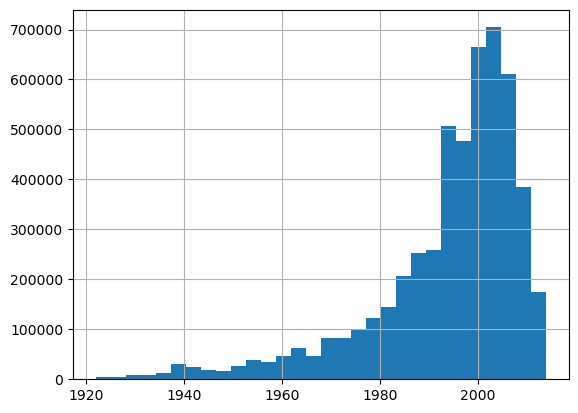

In [76]:
train = pd.merge(train, year_data, on = 'item', how = 'left')
train.dropna()['year'].astype('int').hist(bins = 30) 

오래된 영화도 일부 있지만 최신 영화가 대부분을 차지하네요. 2000년 인근에 제작한 영화가 가장 인기가 좋습니다.

In [89]:
tem = pd.get_dummies(genre_data) # get_dummies : 원-핫 인코딩을 진행해주는 함수입니다.
# groupby와 sum을 이용해 여러 장르를 동시에 고려하게 만들었습니다, reset_index : 인덱스(여기선 item)를 열로 만들어주는 함수.
genre_data_one = tem.groupby('item').sum().reset_index() 
genre_data_one.sample(5)

,item,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
298,495,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
906,1648,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4653,33836,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
6374,90522,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5024,48059,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0


get_dummies 함수를 사용해 원 핫 인코딩을 진행했고 영화별로 묶어서 한 영화가 여러 장르를 가지고 있다면 모두 1이 나오게 했습니다.

예를들어 48059 영화는 Animation, Children, Comedy, Drama 특성이 있다면 모두 1이 출력되게 합니다.

In [102]:
train_genre = pd.merge(train, genre_data_one, on = 'item', how = 'left')
# drop : 열 삭제, describe : 요약 통계량, .T : 가로 새로 뒤집기, ascending = False : 내림차순
train_genre.drop(['user', 'item','time','log_year', 'month','year'], axis= 1).describe().T['mean'].sort_values(ascending = False)

genre_Drama          0.487229
genre_Comedy         0.333500
genre_Action         0.291961
genre_Thriller       0.278531
genre_Adventure      0.233445
genre_Crime          0.196816
genre_Romance        0.173411
genre_Sci-Fi         0.166429
genre_Fantasy        0.119858
genre_Mystery        0.095646
genre_Children       0.077201
genre_Animation      0.071930
genre_Horror         0.066686
genre_War            0.059593
genre_Musical        0.038730
genre_Western        0.018503
genre_Documentary    0.017470
genre_Film-Noir      0.013658
Name: mean, dtype: float64

앞선 전처리를 바탕으로 영화 기록 로그에 가장 많이 찍힌 데이터를 알아봤습니다.

거의 절반은 우선 드라마로 구성되어있고 코미디, 액션 순으로 인기가 많은 모습입니다.

2% 미만의 장르도 3개나 되는 것도 신경써야할 부분인 것 같아요.

작가나 감독 관련해서는 미션 EDA에 잘 나와있어서 생략하겠습니다.